In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

<b><font size="6" color="red">09_wine품질등급예측(다중분류)</font></b>

# red wine 품질 등급 예측
```
1. 데이터셋 확보 & 전처리
    독립변수와 타겟변수 분리 -> 독립변수 스케일조정(StandardScaler)-> 타겟변수원핫인코딩(get_dummies) -> 훈련셋과 테스트셋분리(train_test_split)
2. 모델 구성(입력11, 출력?)
3. 모델학습과정 설정(다중분류로 설정)
4. 모델 학습(callbacks 이용)
5. 모델 평가 - 그래프, 평가(테스트셋), 교차표
6. 모델 저장/사용
```

In [2]:
import numpy as np
import pandas as pd # read_csv, get_dummies, crosstab
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras import metrics # compile
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt

# 1. 데이터셋 확보 & 전처리
 - 독립변수와 타겟변수 분리 -> 독립변수 스케일조정(StandardScaler) -> 타겟변수원핫인코딩(get_dummies) -> 훈련셋과 테스트셋분리(train_test_split)

In [4]:
# 데이터 읽어오기
# np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
# np.genfromtxt('data/winequality-red.csv', delimiter=';', skip_header=1)
#redwine = pd.read_csv('./data/winequality-red.csv', sep=';')
redwine = pd.read_csv('../../letNote/05_DeepLearning/data/winequality-red.csv', sep=';')
redwine

# 고정 산도(fixed acidity)
# 휘발성 산도(volatile acidity)
# 구연산(citric acid)
# 잔여 당분(residual sugar)
# 염화물(chlorides)
# 유리 아황산염(free sulfur dioxide)
# 총 아황산염(total sulfur dioxide)
# 밀도(density)
# pH
# 황산염(sulphates)
# 알코올(alcohol)
redwine.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
redwine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
redwine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [7]:
# 독립변수, 타겟변수 분리
X_redwine = redwine.iloc[:, :-1].values # to_numpy와 유사. numpy배열로
y_redwine = redwine.iloc[:, -1] # 3,4,5,6,7,8
X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [8]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaler.fit(X_redwine)
scaled_X_redwine = scaler.transform(X_redwine)
# 다중분류를 위한 타겟변수의 원핫인코딩 -> numpy 배열로 변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy() # 3-8까지의 등급이 배열로 변경됨

In [10]:
scaled_X_redwine, Y_redwine

(array([[-0.52835961,  0.96187667, -1.39147228, ...,  1.28864292,
         -0.57920652, -0.96024611],
        [-0.29854743,  1.96744245, -1.39147228, ..., -0.7199333 ,
          0.1289504 , -0.58477711],
        [-0.29854743,  1.29706527, -1.18607043, ..., -0.33117661,
         -0.04808883, -0.58477711],
        ...,
        [-1.1603431 , -0.09955388, -0.72391627, ...,  0.70550789,
          0.54204194,  0.54162988],
        [-1.39015528,  0.65462046, -0.77526673, ...,  1.6773996 ,
          0.30598963, -0.20930812],
        [-1.33270223, -1.21684919,  1.02199944, ...,  0.51112954,
          0.01092425,  0.54162988]]),
 array([[0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        ...,
        [0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]], dtype=uint8))

In [11]:
# 독립변수:scaled_X_redwine & 타겟변수:Y_redwine
scaled_X_redwine.shape, Y_redwine.shape

((1599, 11), (1599, 6))

In [42]:
# 훈련셋과 테스트셋 분리(층화추출) = 7:3
X_train, X_test, Y_train, Y_test =train_test_split(scaled_X_redwine, Y_redwine,
                                                  train_size=0.7,
                                                  stratify=Y_redwine,
                                                  random_state=3)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1119, 11), (480, 11), (1119, 6), (480, 6))

In [43]:
Y_redwine.shape, Y_train.shape, Y_test.shape

((1599, 6), (1119, 6), (480, 6))

In [44]:
np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True),
      pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),
      pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]

array([[0.42589118, 0.42627346, 0.425     ],
       [0.39899937, 0.39857015, 0.4       ],
       [0.12445278, 0.12421805, 0.125     ],
       [0.03314572, 0.03306524, 0.03333333],
       [0.01125704, 0.01161752, 0.01041667],
       [0.00625391, 0.00625559, 0.00625   ]])

# 2. 모델 구성(입력11, 출력 6)

In [63]:
model = Sequential()
model.add(Input(11))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=80, activation='relu'))
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=40, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, 'relu'))
model.add(Dense(units=20, activation='relu'))
model.add(Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 100)               1200      
                                                                 
 dense_14 (Dense)            (None, 80)                8080      
                                                                 
 dense_15 (Dense)            (None, 60)                4860      
                                                                 
 dense_16 (Dense)            (None, 40)                2440      
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_17 (Dense)            (None, 30)                1230      
                                                                 
 dense_18 (Dense)            (None, 20)               

# 3. 모델 학습과정 설정(다중분류에 맞는 설정)

# 4. 학습(callbacks 이용)

In [64]:
%%time
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

class CustomHistory(Callback): # on_epoch_end()함수가 epoch수행후 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch==1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'\
                  .format(self.epoch,
                         logs.get('loss'),
                         logs.get('accuracy'),
                         logs.get('val_loss'),
                         logs.get('val_accuracy')
                )
            )
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder): # 폴더 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
# 콜백 객체
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                    filepath=file,
                    monitor='val_accuracy', # 모니터링 지표:loss, val_loss, accuracy
                    save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                    mode = 'max',
                    verbose=0) # 로그 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
# 학습
hist = model.fit(X_train, Y_train, epochs=200, batch_size=200,
                validation_split=0.2, # 학습셋의 20%는 검증셋으로 
                verbose=0, # 로그출력 막음(콜백함수에서 출력)
                callbacks=[earlyStopping,
                          customHistory,
                          checkpoint])

1번째 loss:1.7785, acc:0.1173, val_loss:1.7441, val_acc:0.1027
5번째 loss:1.4537, acc:0.3911, val_loss:1.4312, val_acc:0.3705
10번째 loss:1.1911, acc:0.5676, val_loss:1.2425, val_acc:0.5848
15번째 loss:1.0257, acc:0.5978, val_loss:1.0747, val_acc:0.6161
20번째 loss:0.9688, acc:0.6168, val_loss:0.9983, val_acc:0.6250
25번째 loss:0.9154, acc:0.6335, val_loss:0.9618, val_acc:0.6339
30번째 loss:0.8693, acc:0.6492, val_loss:0.9576, val_acc:0.6071
35번째 loss:0.8252, acc:0.6782, val_loss:0.9592, val_acc:0.6161
40번째 loss:0.7708, acc:0.6994, val_loss:0.9489, val_acc:0.6205
45번째 loss:0.7177, acc:0.7173, val_loss:0.9580, val_acc:0.6205
50번째 loss:0.6796, acc:0.7453, val_loss:0.9684, val_acc:0.6250
55번째 loss:0.6072, acc:0.7642, val_loss:1.0444, val_acc:0.6339
CPU times: total: 3.97 s
Wall time: 2.61 s


# 5. 모델 평가

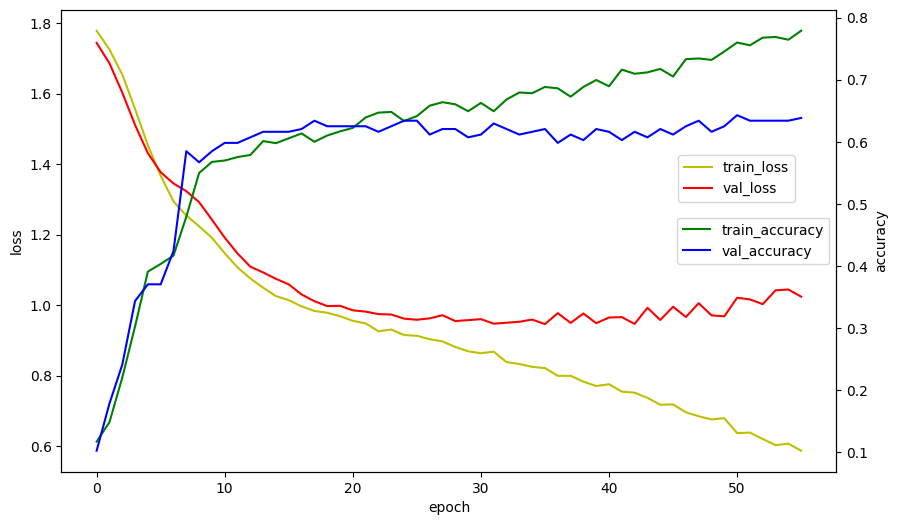

In [65]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [66]:
# 모델 평가
loss_and_acc =model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:1.0896, accuracy:0.5854


In [67]:
model1 = load_model('model/wine-051-loss1.0211-acc0.6429.h5')
loss_and_acc1 =model1.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc1[0]:.4f}, accuracy:{loss_and_acc1[1]:.4f}')

loss:1.0220, accuracy:0.6021


In [71]:
# 교차표 (실제값과 예측값을 1차원 데이터로)
real = Y_test.argmax(axis=1) + 3 # 실제값
# real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1) + 3
#pred = np.argmax(model.predict(X_test), axis=1)

pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

15/15 [==============================] - 0s 905us/step


predict,5,6,7
real,,,
3,3,0,0
4,13,1,2
5,156,44,4
6,71,89,32
7,5,19,36
8,1,0,4


# 6. 모델 사용

In [72]:
X_redwine[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ])

In [78]:
input_data = [7.4, 0.7, 0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]
scaled_data = scaler.transform([input_data])
print(scaled_data)
model.predict(scaled_data).argmax(axis=1)+3

[[-0.52835961  0.96187667 -1.39147228 -0.45321841 -0.24370669 -0.46619252
  -0.37913269  0.55827446  1.28864292 -0.57920652 -0.96024611]]
1/1 [==============================] - 0s 26ms/step


array([5], dtype=int64)